<a href="https://colab.research.google.com/github/gabrielfernandorey/ITBA-NLP/blob/main/NLP_02_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Practico NLP - Detección de Tópicos y clasificación
- ITBA 2024
- Alumno: Gabriel Rey
---

### >>> Solo para correr en Colab

In [ ]:
from google.colab import userdata

git_token = userdata.get('GIT_TOKEN')
git_username = "gabrielfernandorey"
git_repository = "ITBA-NLP.git"

!git clone https://{git_token}@github.com/{git_username}/{git_repository}

!pip install -r /content/ITBA-NLP/requirements.txt
!pip install python-dotenv

## MODELO

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
from matplotlib import pyplot as plt
import os
import json
import pickle
from datetime import datetime, date
from dateutil.parser import parse
from dotenv import load_dotenv

from NLP_tools import Cleaning_text, top_keywords, top_entities, get_topic_name, best_document, clean_all, topic_documents
from core.functions import *

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF

from tqdm import tqdm

from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer

In [3]:
from opensearch_data_model import Topic, TopicKeyword, News, os_client, TOPIC_INDEX_NAME, NEWS_INDEX_NAME
from opensearch_io import init_opensearch, get_news
from opensearchpy import helpers

from openai import OpenAI

### Path

In [4]:
load_dotenv()
PATH_REMOTO='/content/ITBA-NLP/data/'
PATH=os.environ.get('PATH_LOCAL', PATH_REMOTO)
PATH

'C:/Users/gabri/OneDrive/Machine Learning/Github/ITBA-NLP/data/'

In [5]:
if PATH == os.environ.get('PATH_LOCAL'):
    client = OpenAI(api_key= os.environ.get('OPENAI_API_KEY'))
else:
    # from google.colab import userdata
    client = OpenAI(api_key= userdata.get('OPENAI_API_KEY'))

### Inicializamos la base vectorial

In [6]:
init_opensearch()

El índice Topic ya existe. Saltando inicialización de base de datos.
El índice News ya existe. Saltando inicialización de base de datos.


### Data de noticias original

In [7]:
df_params = {'0_1000':'0_1000_data.parquet',
             '1000_2000':'1000_2000_data.parquet',
             '2000_3000':'2000_3000_data.parquet',
             'df_joined':'df_joined_2024-04-01 00_00_00.parquet'
            }

chunk = '0_1000' 
#chunk = '1000_2000' 
df_parquet = pd.read_parquet(PATH+df_params[chunk])
data = list(df_parquet['in__text'])

# Cantidad total de documentos
print(chunk)


0_1000


In [8]:
# Cargar vocabulario
with open(PATH+f'modelos/vocabulary_{chunk}.json', 'r') as json_file:
    vocab = json.load(json_file)
len(vocab)

6833

In [9]:
# Cargar documentos preprocesados
with open(PATH+f'modelos/proc_data_{chunk}.json', 'r') as json_file:
    proc_data = json.load(json_file)
len(proc_data)

1000

### StopWords

In [10]:
# Stopwords
SPANISH_STOPWORDS = list(pd.read_csv(PATH+'spanish_stop_words.csv' )['stopwords'].values)

### Modelo

In [11]:
tfidf_vectorizer = TfidfVectorizer(
        tokenizer=None,
        max_df=0.9,
        min_df=0.1,
        ngram_range=(1, 2),
        vocabulary=vocab,
        # max_features=100_000
)
tfidf_vectorizer.fit(data)

TfidfVectorizer(max_df=0.9, min_df=0.1, ngram_range=(1, 2),
                vocabulary=['tasas', 'Cemar de Rosario', 'Sporting',
                            'Gimena Accardi', 'Universidad Austral',
                            'Duncan Burrage', 'Turquía', 'Joaquín Furriel',
                            'Serú', 'ocupación plena', 'denunciante indignado',
                            'Furriel Instagram', 'Deportivo de Tucumán',
                            'entrenador físico', 'Cataratas del Niágara',
                            'curso', 'riqueza', 'Brigada de Comandos',
                            'segunda ciudad', 'Ruta 2', 'actitud', 'hijitos',
                            'FA Cup', 'granos', 'Bravo Argentina', 'esculturas',
                            'autoridades', 'rápido operativo',
                            'Historia Ximena Capristo', 'Sant Joan Despí', ...])

Capas del modelo BERTopic

In [12]:
# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
# Step 4 - Tokenize topics
vectorizer_model = tfidf_vectorizer
# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()
# Step 6 - (Optional) Fine-tune topic representations with a `bertopic.representation` model
# representation_model = KeyBERTInspired()

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,              # Step 1 - Extract embeddings
  umap_model=umap_model,                        # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,                  # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,            # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                    # Step 5 - Extract topic words
  # representation_model=representation_model,  # Step 6 - (Optional) Fine-tune topic represenations
  # language='multilingual',                    # This is not used if embedding_model is used.
  verbose=True,
  # calculate_probabilities=True
)

### Datos de Entrenamiento a recuperar

In [11]:
chunk = "app"
# Cargar modelo entrenado o saltar celda y entrenar
topic_model = BERTopic.load(PATH+f"modelos/bertopic_model_{chunk}")
#topics = np.load(PATH+f"modelos/topics_{chunk}.npy")
#probs = np.load(PATH+f"modelos/probs_{chunk}.npy")

# Cargar los embeddings
docs_embedding = np.load(PATH+f"modelos/docs_embeddings_{chunk}.npy")

### Entrenamiento

In [13]:
# Entrenamiento
topics, probs = topic_model.fit_transform(proc_data)

2024-07-30 10:29:00,055 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2024-07-30 10:31:00,625 - BERTopic - Embedding - Completed ✓
2024-07-30 10:31:00,627 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-07-30 10:31:19,883 - BERTopic - Dimensionality - Completed ✓
2024-07-30 10:31:19,891 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-07-30 10:31:20,048 - BERTopic - Cluster - Completed ✓
2024-07-30 10:31:20,055 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-07-30 10:31:21,741 - BERTopic - Representation - Completed ✓


In [14]:
# Obtenemos embeddings de todos los documentos
docs_embedding = topic_model.embedding_model.embed(data)

### Datos de entrenamiento a guardar

In [18]:
# Grabar modelo
topic_model.save(PATH+f"modelos/bertopic_model_{chunk}")
np.save(PATH+f"modelos/topics_{chunk}.npy", topics)
np.save(PATH+f"modelos/probs_{chunk}.npy", probs)

# Guardar los embeddings en un archivo de NumPy
np.save(PATH+f"modelos/docs_embeddings_{chunk}.npy", docs_embedding)

2024-07-30 10:33:46,929 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


## Resultados y operaciones con el modelo

In [15]:
print(f"Cantidad de tópicos {len(set(topics))} (incluye topico -1)")

Cantidad de tópicos 14 (incluye topico -1)


In [12]:
# Obtener documentos de cada tópico
topic_freq = topic_model.get_topic_freq()

# Imprimir el número de tópicos encontrados (incluyendo el tópico -1)
num_topics = len(topic_freq)
print(f"Número de tópicos encontrados: {num_topics} (incluye el topico -1)")

# Imprimir la cant de documentos de cada tópico
print(topic_freq)

Número de tópicos encontrados: 16 (incluye el topico -1)
    Topic  Count
4       0    163
0      -1    129
6       1    126
7       2    120
1       3    112
9       4     93
13      5     45
8       6     43
10      7     31
5       8     28
12      9     26
2      10     22
14     11     20
3      12     18
11     13     12
15     14     12


### Recuperar todos los topicos y sus etiquetas generadas por el modelo

In [13]:
topic_labels = topic_model.generate_topic_labels()
topic_labels

['-1_es_tarjeta_años',
 '0_vs_estadio_partido',
 '1_relojes_presidenta_congresistas',
 '2_precios_es_aumento',
 '3_policía_mujer_robo',
 '4_furia_es_película',
 '5_estafadores_feria artesanal_víctima',
 '6_guerra_islas_veteranos',
 '7_reacción alérgica_periodista_cirugía',
 '8_ocupación_semana_turismo',
 '9_cadena_radio_mañana',
 '10_siria_ataque_consulado',
 '11_victoria_golf_mujer',
 '12_dengue_mosquitos_repelente',
 '13_dólar_notificaciones_deporte',
 '14_vientos_alerta naranja_viento']

### Buscar topicos ingresando un texto

In [23]:
topic_res = topic_model.find_topics("cambio climatico")
topic_res

([10, 9, 0, 12, 4], [0.48604098, 0.27345338, 0.2677128, 0.2284346, 0.2185418])

In [37]:
topic_labels[topic_res[0][np.argmax(topic_res[1])]+1]

'10_vientos_la luna_alerta naranja'

### Buscar los titulos de los primeros n documentos de un topico

In [38]:
# Obtener los n documentos de un tópico
topic_id = 7
n_docs = 5
topic_docs_idx = [i for i, (doc, topic) in enumerate(zip(list(df_parquet['in__title']), topics)) if topic == topic_id]
n_docs = n_docs if n_docs <= len(topic_docs_idx) else len(topic_docs_idx)

print(f"{n_docs} de {len(topic_docs_idx)} titulos de noticias encontrados en el tópico {topic_id:}")
for idx in topic_docs_idx[:n_docs]:
    print("- ",df_parquet.iloc[idx]['in__title'])

5 de 22 titulos de noticias encontrados en el tópico 7
-  Darío Barassi habló de su salud tras una complicación luego de su cirugía: "Me aconsejaron quedarme internado"
-  Darío Barassi tuvo que ser internado nuevamente: qué le pasó
-  Internaron nuevamente a Jorge Lanata
-  Dieron de alta a Roxy Vázquez tras ser internada: "Fue un cuadro viral severo"
-  Jorge Lanata, internado: el conductor volvió a la Fundación Favaloro por un problema respiratorio


#### Busqueda de documentos por topico, ordenados por mayor probabilidad

In [14]:
topic = 14
# topic = np.random.randint(0, len(docs_per_topics)-1) # Aleatorio

docs_per_topics = [i for i, x in enumerate(topic_model.topics_) if x == topic]
probs = topic_model.probabilities_[docs_per_topics]

print("Ejemplo para tópico:", topic)

doc_probs_x_topic = []
news_nmf = []
title_nmf = []
for i, doc in enumerate(docs_per_topics):
    doc_probs_x_topic.append([df_parquet.index[doc], df_parquet.iloc[doc].in__title, round(probs[i],4)])
    news_nmf.append(df_parquet.iloc[doc].in__text)
    title_nmf.append(df_parquet.iloc[doc].in__title)

df_query_1 = pd.DataFrame(doc_probs_x_topic, columns=['ID','titulo','score'])
print(len(df_query_1), "docs encontrados")
df_query_1.sort_values('score', ascending=False)

Ejemplo para tópico: 14
12 docs encontrados


,ID,titulo,score
0,105641112,"La inteligencia artificial responde mejor si somos emocionales en nuestras preguntas, demuestra estudio",1.0000
1,105585338,Flor Vigna se quebró al hablar sobre su separación de Luciano Castro,1.0000
2,105591758,Israel bombardeó el consulado de Irán en Damasco y mató a un importante general de la Guardia Revolucionaria Iraní,1.0000
4,105638589,Spotify lanza una nueva opción de suscripción para audiolibros: cuánto cuestan y dónde se puede acceder,1.0000
5,105595234,Advierten demoras en la frontera con Chile por el regreso de turistas a Mendoza,1.0000
7,105595297,"Bolivia: por un accidente fatal, le pidieron a Boca no regresar cuando termine el partido",1.0000
8,105594647,Denunció al vecino por comerse un asado en el Viernes Santo,1.0000
9,105558425,"Clima en Córdoba: fuerte descenso de la temperatura para el lunes, ¿llega la lluvia?",1.0000
10,105594412,"Alerta por viento y lluvia, este martes y miércoles, en Neuquén y Río Negro: habrá ráfagas de 120 km/h",1.0000
11,105640874,🟠 Lanzaron una alerta naranja por fuertes vientos: qué provincias serán afectadas,1.0000


#### Palabras clave del topico

In [46]:
# Obtener las palabras clave para un topico dado
topic = 10
topic_keywords = topic_model.get_topic(topic)
print("Topico:", topic)
print(topic_keywords)

Topico: 10
[('vientos', 0.09977259625176492), ('la luna', 0.07679682318570355), ('alerta naranja', 0.06944336127359137), ('eclipse solar', 0.0630739403005475), ('eclipse total', 0.05979648139110144), ('lluvias', 0.058534794760510815), ('viento', 0.05738810416124283), ('ráfagas', 0.05337818505336163), ('martes', 0.05330110094984347), ('grados', 0.052292204405395185)]


### Criterio de corte (umbral)
El criterio de corte utilizado para filtrar las noticias que pertenecen a un topico es la media.

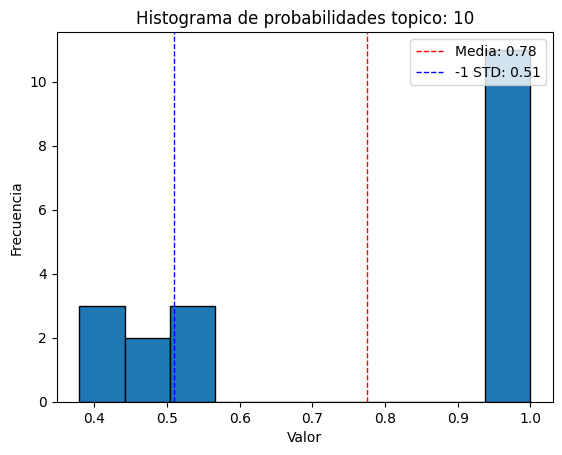

In [47]:
# Calcular la media, el desvío estándar

mean = np.mean([fila[2] for fila in doc_probs_x_topic])
std_dev = np.std([fila[2] for fila in doc_probs_x_topic])

# Crear el histograma
plt.hist([fila[2] for fila in doc_probs_x_topic], bins=10, edgecolor='black')

# Añadir líneas para la media, la moda y el desvío estándar
plt.axvline(mean, color='r', linestyle='dashed', linewidth=1, label=f'Media: {mean:.2f}')
plt.axvline(mean - std_dev, color='b', linestyle='dashed', linewidth=1, label=f'-1 STD: {mean - std_dev:.2f}')


# Añadir títulos y etiquetas
plt.title(f'Histograma de probabilidades topico: {topic}')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.legend()

# Mostrar el gráfico
plt.show()

#### Documentos mas representativos de un topico

In [15]:
topic = 14

- [1]  Desde el metodo del modelo

In [16]:
docs_representative = topic_model.get_representative_docs(topic=topic)
docs_representative

['Se espera una jornada mayormente nublada en AMBA.\n\nPara este martes, el Servicio Meteorológico Nacional (SMN) mantiene advertencias por lluvias, vientos y el viento local Zonda en la Patagonia, la región pampeana y Cuyo respectivamente. Con 0% de probabilidad de precipitaciones, en AMBA se pronostica una jornada mayormente nublada, con una temperatura máxima de 22 grados y una mínima de 16.\n\nEl tiempo nublado se sostiene en ciudades costeras como Mar del Plata, Pinamar y Cariló, aunque en estas localidades se espera una mañana con neblina. La situación es similar en algunos de los principales destinos turísticos del interior del país: en las capitales de Mendoza, Santa Fe y Córdoba el cielo estará parcialmente nublado durante todo el día y sin probabilidad de precipitaciones.\n\nVientos fuertes y lluvias: el pronóstico en el interior del país\n\nLas provincias de Chubut, Neuquén y Río Negro se encuentran en alerta naranja por lluvias. Se trata de un nivel intermedio de advertenci

- [2] Por busqueda de probabilidad de documentos (en opensearch) perteneciente al topico ( utilizando el umbral de corte )

In [17]:

# Definir la función de estilo
def color_rows(row, label, value):
    if row[label] >= value:
        return ['color: cyan'] * len(row)
    else:
        return [''] * len(row)

# Agrupamos documentos por topico
docs_per_topics = [i for i, x in enumerate(topic_model.topics_) if x == topic]

# Obtener los IDs de los documentos y sus probabilidades
docs_ids = []
docs_topic = []
doc_probs_x_topic = []
for doc_ID in tqdm(docs_per_topics):
    docs_ids.append(df_parquet.index[doc_ID])
    doc_probs_x_topic.append(probs[doc_ID])

# Calcular la media, el desvío estándar
threshold = np.mean(doc_probs_x_topic)

# Crear una consulta de múltiples IDs
index_name = 'news'
mget_query = {
    "docs": [{"_index": index_name, "_id": doc_id} for doc_id in docs_ids]
}

# Realizar la búsqueda de múltiples IDs
response = os_client.mget(body=mget_query, index=index_name)

# Procesar la respuesta
for i, doc in enumerate(response['docs']):
    if doc['found']:
        idx = doc['_id']
        title = df_parquet.iloc[docs_per_topics[i]].in__title
        text = df_parquet.iloc[docs_per_topics[i]].in__text
        prob_doc = probs[docs_per_topics[i]]

        docs_topic.append([idx, title, prob_doc, text[:40]])


df_view = pd.DataFrame(docs_topic, columns = ['indice','titulo','prob','text']).sort_values('prob', ascending=False)
df_view.style.apply(lambda row: color_rows(row, 'prob', threshold), axis=1)


  0%|          | 0/12 [00:00<?, ?it/s]


IndexError: index 96 is out of bounds for axis 0 with size 12

Nota: Los documentos mas representativos encontrados utilizando el metodo "get_representative_docs" no refleja lo mismo que encontrando los documentos por probabilidades maximas

- [3] Por similitud coseno del topico a los tres documento mas cercanos

In [19]:
# Obtenemos la matriz de similitud coseno entre topicos y documentos
sim_matrix = cosine_similarity(topic_model.topic_embeddings_, docs_embedding)
sim_matrix.shape

(16, 1000)

In [20]:
# Similitud coseno entre el topico y los documentos del topico elegido
s_coseno = []
for i in docs_per_topics:
    s_coseno.append(cosine_similarity([topic_model.topic_embeddings_[topic + 1]], [docs_embedding[i]])[0][0])

# Indices
idx_coseno_sort = np.argsort(s_coseno)[::-1]

for idx in idx_coseno_sort[:3]:
    print(idx, df_parquet.iloc[docs_per_topics[idx]].in__title)


0 La inteligencia artificial responde mejor si somos emocionales en nuestras preguntas, demuestra estudio
2 Israel bombardeó el consulado de Irán en Damasco y mató a un importante general de la Guardia Revolucionaria Iraní
1 Flor Vigna se quebró al hablar sobre su separación de Luciano Castro


Nota: Del mismo modo que en el punto anterior, los documentos mas cercanos al topico no coinciden, no son exactamente los mismos que los hallados en el punto 1

- [4] Primer documento mas cercano al embedding del topico

In [21]:
# Documento de maxima similitud con el topico

simil_docs_topic = sim_matrix[topic + 1].argmax()
print(f"Noticia de maxima similitud con el topico: {topic}")
print(f"Doc ID: {df_parquet.index[simil_docs_topic]}")
print(f"Titulo: {df_parquet.iloc[simil_docs_topic].in__title}")
print(f"Noticia: {data[simil_docs_topic][:80]}...")
best_doc = data[simil_docs_topic]

Noticia de maxima similitud con el topico: 14
Doc ID: 105641112
Titulo: La inteligencia artificial responde mejor si somos emocionales en nuestras preguntas, demuestra estudio
Noticia: La amabilidad y las emociones hacen que Chat GPT brinde mejores respuestas - (Im...


### keywords de un topico y documentos pertenecientes (vista del dataframe)

In [92]:
# Observamos keywords del topico y documentos
topic_docs_idx = [i for i, (_, topic) in enumerate(zip(list(df_parquet.index), topics)) if topic == topic_id]
hstack = np.hstack((np.array(topic_docs_idx).reshape(-1,1), np.array(df_parquet["in__title"])[topic_docs_idx].reshape(-1,1)))

df_data = pd.DataFrame(hstack, columns=["idx","title"])

s_coseno = []
for i in topic_docs_idx:
    s_coseno.append(cosine_similarity([topic_model.topic_embeddings_[topic_id + 1]], [docs_embedding[i]])[0][0])

print(topic_model.topic_labels_[topic_id])

df_data['similitud'] = s_coseno

umbral = 0.7 # umbral discrecional

df_filtered = df_data[df_data["similitud"] > umbral].sort_values("similitud", ascending=False)
df_filtered

7_reacción alérgica_cuerdas vocales_cirugía_periodista


,idx,title,umbral
7,328,Preocupación por Lanata: internado por problemas respiratorios,0.877170
5,289,Internaron nuevamente al periodista Jorge Lanata,0.839079
4,262,"Jorge Lanata, internado: el conductor volvió a la Fundación Favaloro por un problema respiratorio",0.824902
11,623,Darío Barassi explicó por qué tuvieron que internarlo de urgencia,0.817513
15,751,Preocupación por la salud de Darío Barassi: fue internado de urgencia,0.798851
18,778,Darío Barassi volvió a ser internado y generó suma preocupación en sus fanáticos,0.792726
10,501,Darío Barassi tuvo que volver a ser internado tras su operación: las razones,0.779267
0,200,"Darío Barassi habló de su salud tras una complicación luego de su cirugía: ""Me aconsejaron quedarme internado""",0.772089
6,302,Internaron a Darío Barassi: el conductor contó qué le pasa,0.760845
14,716,"Darío Barassi tuvo que volver a ser internado tras su cirugía: ""A veces las cosas no son como uno quiere""",0.753838


#### Keywords de solo un topico

In [76]:
keywords = topic_model.topic_representations_[topic]
topic_keywords = [TopicKeyword(name=keyword, score=score) for keyword, score in keywords if keyword != '']
topic_keywords

[{'name': 'estafadores', 'score': 0.0937460832042136},
 {'name': 'feria artesanal', 'score': 0.04601777559626258},
 {'name': 'víctima', 'score': 0.04311696223115434},
 {'name': 'fraudes', 'score': 0.04102924950063795},
 {'name': 'anuncio', 'score': 0.03963630779135704},
 {'name': 'internet', 'score': 0.03834823764090838},
 {'name': 'es', 'score': 0.036737074629876215},
 {'name': 'delincuentes', 'score': 0.03650861205370464},
 {'name': 'tu', 'score': 0.03627480362971385},
 {'name': 'contenido', 'score': 0.03615993019809183}]

In [77]:
# Calculo de umbral de corte para las keywords
def keywords_umbral(topic_keywords):
    freq_k = []
    for name_score in topic_keywords:
        freq_k.append(name_score['score'])
    umbral_k = np.array(freq_k).mean()
    print(umbral_k)

    topic_keywords_top = {}
    for name_score in topic_keywords:
        if name_score['score'] >= umbral_k:
            topic_keywords_top[name_score['name']] = name_score['score']

    return topic_keywords_top

keywords_umbral(topic_keywords)

0.044757503647592047


{'estafadores': 0.0937460832042136, 'feria artesanal': 0.04601777559626258}

#### Entidades de los n documentos mas cercanos al embedding del topico (buscando en opensearch)

In [89]:
# Agrupamos documentos por topico
docs_per_topic = [i for i, x in enumerate(topic_model.topics_) if x == topic]

# Obtener los IDs de los documentos y sus probabilidades
docs_ids = []
docs_topic = []

#doc_probs_x_topic = []
for doc_ID in tqdm(docs_per_topic):
    docs_ids.append(df_parquet.index[doc_ID])

# Crear una consulta de múltiples IDs
index_name = 'news'
mget_query = { "docs": [{"_index": index_name, "_id": doc_id} for doc_id in docs_ids] }

# Realizar la búsqueda de múltiples IDs
response = os_client.mget(body=mget_query, index=index_name)

# Procesar la respuesta
for i, doc in enumerate(response['docs']):
    if doc['found']:
        idx = doc['_id']
        title = doc['_source']['title']
        prob = doc['_source']['prob']
        entities = doc['_source']['entities']
        
        docs_topic.append([idx, title, prob, entities])

df_view = pd.DataFrame(docs_topic, columns = ['indice','titulo','prob','entidades']).sort_values('prob', ascending=False)

n_docs = 5 # n docs cercanos
entities_topic = []
for doc in df_view[:n_docs].iterrows():
    entities_topic.append(doc[1][3])

# Crear un diccionario para contar en cuántos documentos aparece cada palabra
document_frequencies = defaultdict(int)

# Crear un conjunto para cada documento y contar las palabras únicas
for lista in entities_topic:
    unique_words = set(lista)
    for palabra in unique_words:
        document_frequencies[palabra] += 1

# Ordenar las palabras por la frecuencia de documentos de mayor a menor
sorted_frequencies = sorted(document_frequencies.items(), key=lambda item: item[1], reverse=True)

freq_e = []
for item in sorted_frequencies:
    freq_e.append(item[1])
umbral_e = np.array(freq_e).mean()

# Imprimir el resultado ordenado de las primeras 10 entidades segun criterio de corte
topic_entities_top = {}
c=0
for idx in range(len(sorted_frequencies)):
    if sorted_frequencies[idx][1] >= umbral_e:
        if c != 10:
            topic_entities_top[sorted_frequencies[idx][0]] = sorted_frequencies[idx][1]
        else:
            break
        c += 1

topic_entities_top


100%|██████████| 19/19 [00:00<00:00, 33067.13it/s]


{'SMN': 3,
 'Neuquén': 3,
 'Río Negro': 2,
 'Chubut': 2,
 'Mendoza': 2,
 'Servicio Meteorológico Nacional': 2}

In [79]:
topic =10
top_keywords(topic, topic_model)

{'vientos': 0.09977259625176492,
 'la luna': 0.07679682318570355,
 'alerta naranja': 0.06944336127359137}

### Grabar todos los registros en Topic y actualizar en News

In [ ]:
# Grabar todos los topicos en la base
for topic in topic_model.get_topics().keys():
    if topic > -1:

        topic_keywords_top  = top_keywords(topic, topic_model)
        topic_entities_top  = top_entities(topic, topic_model, docs_embedding, data, entities)
        topic_documents_ids, topic_documents_title, threshold  = topic_documents(topic, topic_model, probs, df_parquet, data)
        id_best_doc, title_best_doc, best_doc = best_document(topic, topic_model, docs_embedding, id_data, title_data, data)

        topic_doc = Topic(
            index = topic,
            name = get_topic_name(''.join(topic_documents_title), client),
            vector = list(topic_model.topic_embeddings_[topic + 1 ]),
            similarity_threshold = threshold,
            created_at = datetime.now(),
            to_date = parse('2024-04-02'),
            from_date = parse('2024-04-01'),
            keywords = topic_keywords_top,
            entities = topic_entities_top,
            id_best_doc = id_best_doc,
            title_best_doc = title_best_doc,
            best_doc = best_doc,
        )

        topic_doc.save()

### Recuperar todos los topicos desde el indice Topic de la base

In [ ]:
index_name = 'topic'

topics_list = []
for i, doc in enumerate(Topic.search().query().scan()):
    topics_list.append(doc.to_dict())
    print(topics_list[i]['index'], topics_list[i]['name'])

### Busqueda de 5 documentos del indice de la base news correspondiente a un topico
** (devuelve los docs que han sido marcados en el campo process en True )

In [ ]:
topic_embedding = topics_list[topic]['vector']

index_name = 'news'
# Crear una consulta KNN para buscar embeddings cercanos
knn_query = {
    "size": 5,  # Número de resultados que deseas obtener
    "query": {
        "bool": {
            "must": [
                {
                    "knn": {
                        "vector": {
                            "vector": topic_embedding,
                            "k": 10  # Número de vecinos más cercanos
                        }
                    }
                },
                {
                    "term": {
                        "process": True  # Solo incluir documentos donde 'process' es True
                    }
                }
            ],
            "filter": {
                "exists": {
                    "field": "vector"  # Solo incluir documentos que tienen el campo 'vector'
                }
            }
        }
    }
}
# Realizar la búsqueda
response_topic = os_client.search(index=index_name, body=knn_query)

# Obtener el tópico más cercano
if response_topic['hits']['total']['value'] > 0:
    for i in [hit['_source']['title'] for hit in response_topic['hits']['hits']]:
        print(i)
else:
    print("No se encontraron documentos cercanos al topico dado.")

### Recuperar de la base el documento mas cercano a un topico

In [ ]:
index_name = 'topic'
search_query = {
    'query': {
        'match': {
            'index': 10  # Sustituir 'campo' y 'valor' por campo y valor de búsqueda
        }
    }
}

# Realizar la búsqueda
response = os_client.search(
                            body=search_query,
                            index=index_name
)

texto = response['hits']['hits'][0]['_source']

#Imprimir los resultados
print(f"Topico: {response['hits']['hits'][0]['_source']['name']}")
print("\n"+ texto['best_doc'])

### Nuevo documento consultando embeddings generados por el modelo

In [ ]:
new_doc = "Fuga de presos en San Telmo"

new_doc_embedding = topic_model.embedding_model.embed(new_doc)
sim_matrix_new = cosine_similarity(topic_model.topic_embeddings_, new_doc_embedding.reshape(1, -1))

idx = np.argmax(sim_matrix_new)-1         # Topicos desde -1, 0, 1, ..., n
print(topics_list[idx]['index'], topics_list[idx]['name'])

### Nuevo documento consultando embeddings de la base

In [ ]:
new_doc = "Fuga de presos en San Telmo"

new_doc_embedding = topic_model.embedding_model.embed(new_doc)

# Buscamos en la base a que topico pertenece el nuevo documento
knn_query = {
    "size": 1,
    "query": {
        "knn": {
            "vector": {
                "vector": new_doc_embedding,
                "k" : 3
            }
        }
    }
}
response = os_client.search(index='topic', body=knn_query)

if response['hits']['total']['value'] > 0:
    print(f"Topico: {response['hits']['hits'][0]['_source']['name']}")
    print(f"Estimacion: {response['hits']['hits'][0]['_score']}")
else:
    print(f"Topico no encontrado")

### Graficar los topicos en 3d

In [ ]:
import plotly.express as px

# Obtener los embeddings de los tópicos
topic_embeddings = topic_model.topic_embeddings_

new_doc = "Fuga de presos en San Telmo"
new_doc_embedding = topic_model.embedding_model.embed([new_doc])[0]

total = np.vstack((topic_embeddings, new_doc_embedding))

# Reducir la dimensionalidad de los embeddings a 3D usando UMAP
umap_model = UMAP(n_components=3)
embeddings_3d = umap_model.fit_transform(total)

# Obtener las etiquetas de los tópicos
topics_labels = [str(i)+" "+name['name'] for i, name in enumerate(topics_list) ]

# Crear un DataFrame para Plotly
df = pd.DataFrame(embeddings_3d, columns=['Dim1', 'Dim2', 'Dim3'])
df['Topico'] = ["-1"] + topics_labels + ['>>'+new_doc[:15]] # Identificamos el nuevo documento
df['Etiqueta'] = list(range(-1, len(topic_embeddings)-1)) + [new_doc[:15]]

# Graficar los tópicos en 3D de manera interactiva usando Plotly, ajustando el tamaño del gráfico
fig = px.scatter_3d(df, x='Dim1', y='Dim2', z='Dim3', color='Topico', text='Etiqueta', title='Visualización 3D de Tópicos con BERTopic')


# Ajustar el tamaño del gráfico
fig.update_layout(
    autosize=False,
    width=1200,  # Ancho del gráfico
    height=800,  # Altura del gráfico
    margin=dict(l=65, r=50, b=65, t=90)
)

# Mostrar el gráfico
fig.show()

### Busqueda de un documento por su indice, topico asociado, keywords, entities.

In [ ]:

index_name = 'news'
search_query = {
    'query': {
        'match': {
            '_id': '105594124'
        }
    }
}

# Realizar la búsqueda
response = os_client.search(
                            body=search_query,
                            index=index_name
)
print(f"Texto de Noticia: {response['hits']['hits'][0]['_source']['news'][:200]}...\n")

new_doc_embedding = topic_model.embedding_model.embed(response['hits']['hits'][0]['_source']['news'])

# Define el índice y el campo del vector
index_name = 'topic'
vector_field = 'vector'

# Crear una consulta KNN para buscar el embedding más similar
knn_query = {
    "size": 1,  # Número de resultados que deseas obtener, en este caso 1
    "query": {
        "knn": {
            vector_field: {
                "vector": new_doc_embedding,
                "k": 3  # Número de vecinos más cercanos
            }
        }
    }
}

# Realizar la búsqueda
response_topic = os_client.search(index=index_name, body=knn_query)

# Obtener el tópico más cercano
if response_topic['hits']['total']['value'] > 0:
    closest_topic = response_topic['hits']['hits'][0]['_source']
    print(f"El nuevo documento pertenece al tópico: {closest_topic['index']}")
    print(closest_topic['name'])
    print(f"Estimacion: {closest_topic['similarity_threshold']}")
    print(f"Keywords del topico: {closest_topic['keywords']}")
    print(f"Entidades del topico: {closest_topic['entities']}")

else:
    print("No se encontró un tópico cercano.")

#### Agrupando por embeddings cercanos

In [ ]:
# Eliminamos el topico -1
new_topic_embeddings = topic_embeddings[1:]

# Calcular la similitud del coseno entre los embeddings de los tópicos
similarities = cosine_similarity(new_topic_embeddings)

# Crear una matriz de similitud excluyendo la diagonal
np.fill_diagonal(similarities, 0)

# Encontrar los pares de tópicos más cercanos
topic_pairs = np.dstack(np.unravel_index(np.argsort(similarities.ravel())[::-1], similarities.shape))[0]

# Mostrar los 5 pares de tópicos más cercanos
for i in range(10):
    topic_id_1, topic_id_2 = topic_pairs[i]
    similarity_score = similarities[topic_id_1, topic_id_2]
    print(f"Topico {topic_id_1} y Topico {topic_id_2} tienen una similitud de: {similarity_score:.4f}")

### Recuperar topicos de Opensearch dado una fecha

In [ ]:
def get_topics_opensearch(date_filter=None):

    index_name = 'topic'
    if date_filter:
        # Crear el rango de fecha para filtrar el mismo día completo
        date_filter_gte = f"{date_filter}T00:00:00"
        date_filter_lte = f"{date_filter}T23:59:59"

        query = {
            "size": 100,  
            "query": {
                "bool": {
                    "must": [
                        {"range": {"to_date": {"gte": date_filter_gte, "lte": date_filter_lte}}}
                    ]
                }
            }
        }
    else:
        query = {
            "query": {
                "match_all": {}
            }
        }
    
    response = os_client.search(index=index_name, body=query)

    topics = [hit['_source'] for hit in response['hits']['hits']]
    return topics



topics_os = get_topics_opensearch(date_filter="2024-04-02")

for i in enumerate([hit['name'] for hit in topics_os]):
    print(i)

### Obtener la ultima fecha actualizada de cualquier topico

In [ ]:
def format_date(date_str):
    date_obj = datetime.strptime(date_str, '%Y-%m-%dT%H:%M:%S.%f')
    formatted_date = date_obj.strftime('%Y-%m-%d %H:%M')
    return formatted_date

In [ ]:

db_topics = []
data_topics = {}
for reg in topics_os:
    index = reg['index']
    name = reg['name']
    vector = reg['vector']
    similarity_threshold = reg['similarity_threshold']
    create_at = format_date(reg['created_at'])
    from_date = reg['from_date'][:10]
    to_date = reg['to_date'][:10]
    title_best_doc = reg['title_best_doc']
    id_best_doc = reg['id_best_doc']

    db_topics.append([index, name, round(similarity_threshold, 4), create_at, from_date, to_date])
    data_topics[index] = [name,
                          vector,
                          title_best_doc,
                          reg['best_doc'],
                          reg['entities'],
                          reg['keywords'],
                          similarity_threshold]

# Convertir a DataFrame
df = pd.DataFrame(db_topics, columns=["indice", "nombre", "umbral", "creado", "desde", "hasta"])                      
df

In [ ]:
db_news = get_news()

In [ ]:
# Crear un diccionario para agrupar los registros por fecha (solo día, mes y año)
def dates_count(db_news) -> dict:
    fechas_dict = defaultdict(list)

    # Agrupar registros por fecha
    for registro in db_news:
        fecha_completa = registro[-1]
        fecha_solo_dia = fecha_completa.split('T')[0]  # Tomar solo el día, mes y año
        if fecha_solo_dia not in fechas_dict:
            fechas_dict[fecha_solo_dia] = 1
        else:
            fechas_dict[fecha_solo_dia] += 1
    
    return fechas_dict

In [22]:
def funcion_aux(ID):
    keywords_df = df_parquet[df_parquet.index==ID]['Keyword Name'].values[0]
    entities_df = df_parquet[df_parquet.index==ID]['Entity Name'].values[0]
    fila = df_parquet.index.get_loc(ID)
    print(f"Noticia ID: {ID} {df_parquet[df_parquet.index==ID]['in__title'].values}\n")
    print(f"Entities de dataframe: {entities_df}")
    print(f"Keywords de dataframe: {keywords_df}")
    print("-"*80)
    print(f"Fila: {fila}")
    print(f"Prob. modelo: {probs[fila]}")
    #print(f"Entities calculadas: {entities[fila]}")
    #print(f"Keywords calculadas: {filtered_k_w_n[fila]}")

funcion_aux(105558429)

Noticia ID: 105558429 ['Inicio de semana fresco y con un cielo parcialmente nublado - MDZ Online']

Entities de dataframe: ['']
Keywords de dataframe: ['noreste' 'actividades diarias' 'contingencias climáticas'
 'nubosidad parcial' 'cielo parcialmente nublado']
--------------------------------------------------------------------------------
Fila: 359


IndexError: index 359 is out of bounds for axis 0 with size 12

### Buscar n noticias de la base relacionadas a un topico

In [ ]:
topic = 13
topic_embedding = data_topics[topic][1]
print("Topico: ", data_topics[topic][0])

# Buscamos en la base los documentos del topico elegido
knn_query = {
    "size": 100,
    "query": {
                "knn": {
                        "vector": {
                            "vector": topic_embedding,
                            "k": 120
                        }
                }
            }
    }

response = os_client.search(index='news', body=knn_query)
[f"{str(hit['_score'])} : {hit['_source']['title']}" for hit in response['hits']['hits']]

In [ ]:
id_news     = [hit['_id'] for hit in response['hits']['hits']]
title_news  = [hit['_source']['title'] for hit in response['hits']['hits']]
score_news  = [hit['_score'] for hit in response['hits']['hits']]

others_docs = []
for i in range(len(id_news)):
    others_docs.append([id_news[i], title_news[i], score_news[i]])

df_other_docs = pd.DataFrame(others_docs, columns=['indice', 'titulo', 'probs']) 
df_other_docs

In [ ]:

# Cargar el modelo
embedding_model_x = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# Lista de documentos o frases
sentences = ["Este es un documento de ejemplo.", "Otro ejemplo de documento para generar embedding."]

# Generar embeddings
embeddings_x = embedding_model_x.encode(sentences)

# Imprimir los embeddings
for i, embedding in enumerate(embeddings_x):
    print(f"Documento {i+1}: {embedding}")

In [ ]:
len(embeddings_x)

In [ ]:
topic = 14
documents_ids = [entry['id'] for entry in doc_info if entry['topic'] == topic]
documents_ids

In [ ]:
len(documents_ids)

In [ ]:
def update_news(documents_ids: list, docs_embedding, topics: list) -> bool:
    """
    Marcar en True los registros de noticias procesadas y guardar el embedding correspondiente.
    """

    if len(documents_ids) != len(docs_embedding):
        raise ValueError("El número de IDs de documentos y embeddings no coinciden.")
        return False
    
    index_name = 'news'

    # Construir el cuerpo de la solicitud para el API _bulk
    acciones = []
    for doc_id, embedding, topic in zip(documents_ids, docs_embedding, topics):
        update_body = { 
                        "doc": {
                            "vector": embedding,
                            "topics": topic,   
                            "process": True,
                        }
        }
        accion = {
            "_op_type": "update",
            "_index": index_name,
            "_id": doc_id,
            "doc": update_body["doc"]
        }
        acciones.append(accion)

    # Realizar la actualización por lotes
    helpers.bulk(os_client, acciones)

    return True

In [ ]:
for doc_id, embedding, topic in zip(documents_ids, docs_embedding, topics):
    print(doc_id, embedding, topic)
    break

In [ ]:
query = {
    "size": 100,
    "query": {
        "bool": {
            "must": [
                {"term": {
                    "topics": 10
                }}
            ],
        }
    }
}
                    
response = os_client.search(index='news', body=query)

In [ ]:
for i in [hit['_id'] for hit in response['hits']['hits']]:
        print(i)

In [ ]:
docs_per_topics

In [ ]:
titles_per_topic

In [ ]:
# Stopwords
SPANISH_STOPWORDS = list(pd.read_csv(PATH+'spanish_stop_words.csv' )['stopwords'].values)
SPANISH_STOPWORDS_SPECIAL = list(pd.read_csv(PATH+'spanish_stop_words_spec.csv' )['stopwords'].values)

clean_data = Cleaning_text()

count_vectorizer = CountVectorizer(
                    tokenizer=None,
                    token_pattern=r'(?u)\b\w\w+\b',
                    encoding ='utf-8',
                    ngram_range=(1, 2),
                    max_df=0.8, # significa que cualquier término que aparezca en más del 0.x % de los documentos será ignorado.
                    min_df=2,
                    stop_words=SPANISH_STOPWORDS,
                    # vocabulary=all_tokens,
                    )

nmf_model = NMF(n_components= 2, init='nndsvd' )



In [ ]:
from sklearn.cluster import KMeans

topic = 17
# topic = np.random.randint(0, len(docs_per_topics)-1) # Aleatorio

docs_per_topics = [i for i, x in enumerate(topic_model.topics_) if x == topic]
probs = topic_model.probabilities_[docs_per_topics]
corpus = [data[doc] for doc in docs_per_topics]

titles_per_topic = [df_parquet.iloc[doc]['in__title'] for doc in docs_per_topics]
titles_per_topic

In [ ]:
proc_data = []
for data_in in corpus:
    aux = clean_data.unicode(data_in)
    aux = clean_data.urls(aux)
    aux = clean_data.simbols(aux)
    aux = clean_data.escape_sequence(aux)
    aux = clean_data.str_lower(aux)
    aux = " ".join([ word for word in aux.split() if word.lower() not in SPANISH_STOPWORDS_SPECIAL])
    proc_data.append(aux)

corpus_vect = count_vectorizer.fit_transform(proc_data)

sim = cosine_similarity(corpus_vect, corpus_vect)

# Aplica K-means clustering para dividir en 2 grupos
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(sim)

# Obtiene las etiquetas de los clusters
labels = kmeans.labels_


A = [title if labels[i] == 1 else " " for i, title in enumerate(titles_per_topic) ]
B = [title if labels[i] == 0 else " " for i, title in enumerate(titles_per_topic) ]

data_combined = np.stack((labels, A, B), axis=1)

combined = pd.DataFrame(data_combined)
combined
